In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string
import nltk
nltk.download('wordnet')
from nltk.corpus import gutenberg, stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from collections import Counter

[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## NLP Unsupervised: Wikipedia Movie Plot Summaries ##

For me unsupervised capstone, I decided to see if I could parse out language from the plot summaries of movies on wikipedia. in order to look for commonalities or differences used in the language between movies of different genres.  I tried a couple of different text processing techniques, including TFIDF and CountVectorizer.  I also tried a couple different clustering methods to see how many different clusters would be sufficient for analysis.  And finally, I ran these inputs through a random forest model to see how my clusters did against test data.

In [2]:
movies = pd.read_csv('wiki_movie_plots_deduped.csv')
movies = movies[movies.Genre.str.contains('unknown') == False]
movies = movies[movies.Genre.str.contains('/') == False]
movies = movies[movies.Genre.str.contains(' ') == False]
movies = movies[movies['Release Year'] >= 1960]
movies = movies.groupby("Genre").filter(lambda x: len(x) > 190)
#movies = movies.Plot.apply(lambda x: x.lower())
movies.shape

(11240, 8)

In [3]:
movies.head()

Release Year                              Title Origin/Ethnicity  \
7340          1960  The Dark at the Top of the Stairs         American   
7341          1960                 Desire in the Dust         American   
7343          1960                       Elmer Gantry         American   
7345          1960                             Exodus         American   
7346          1960                  The Facts of Life         American   

               Director                                               Cast  \
7340       Delbert Mann  Robert Preston, Dorothy McGuire, Eve Arden, Sh...   
7341  Robert L. Lippert            Raymond Burr, Martha Hyer, Joan Bennett   
7343     Richard Brooks  Burt Lancaster, Jean Simmons, Arthur Kennedy, ...   
7345     Otto Preminger  Paul Newman, Eva Marie Saint, Ralph Richardson...   
7346       Melvin Frank                Bob Hope, Lucille Ball, Ruth Hussey   

       Genre                                          Wiki Page  \
7340   drama  https://en.wikipedia.org/wiki/The_Dark_at_the_...   
7341   drama   https://en.wikipedia.org/wiki/Desire_in_the_Dust   
7343   drama  https://en.wikipedia.org/wiki/Elmer_Gantry_(film)   
7345   drama   https://en.wikipedia.org/wiki/Exodus_(1960_film)   
7346  comedy  https://en.wikipedia.org/wiki/The_Facts_of_Lif...   

                                                   Plot  
7340  During Prohibition in Oklahoma, Rubin Flood is...  
7341  Lonnie Wilson (Ken Scott), the son of a sharec...  
7343  Elmer Gantry (Burt Lancaster) is a hard-drinki...  
7345  Nurse Katherine "Kitty" Fremont is an American...  
7346  As the yearly vacation of six neighbors, the G...

### Genres ###

Since the original data came with over 100 different genres, I decided to pair down to the top 10 most frequently used.  Out of those 10 however, 2 stand above as the most frequent.  

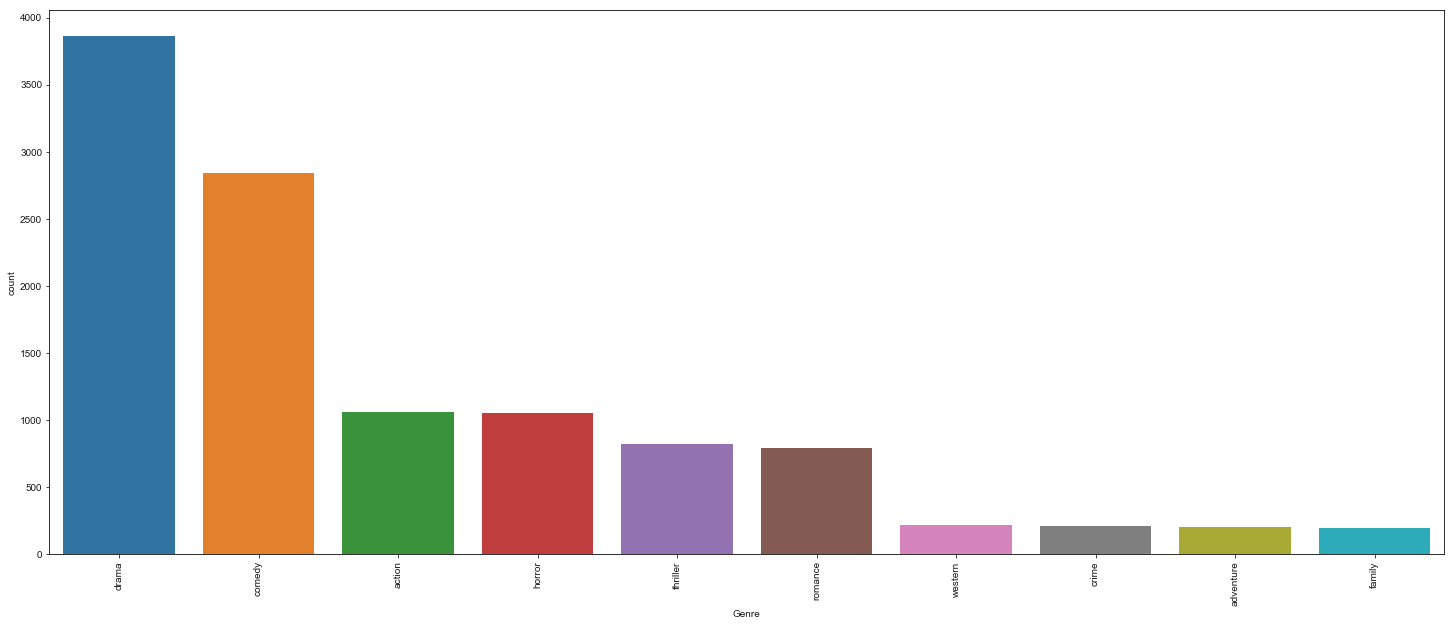

In [4]:
#genre_df = movies.groupby('Genre')
#genre_df.head()
genre = movies['Genre'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = movies['Genre'], order = genre, ax = ax)
sns.set(font_scale=1)
plt.xticks(rotation = 90)
plt.show()

### Plot Parsing ###

Before I could start processing any of the text, I performed some regex processing as well as tokenizing, stemming, and removing common 'stop words' from the plot summaries.  This then gave me a list of the words leftover, with which I could run my analysis over.

In [5]:
df = movies.copy()
df = df.reset_index()

In [6]:
df.Plot = df.Plot.apply(lambda x: x.lower())
df.Plot = df.Plot.str.replace(r'[^\d\w\s]+', '')
df.Plot = df.Plot.str.replace('\r', '')
df.Plot = df.Plot.str.replace('\n', '')
df.Plot = df.Plot.str.replace('[^A-Za-z]', ' ')

In [7]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

df['stemmed'] = df.Plot.apply(lambda x: stemmer.stem(x))
df['tokens'] = df.stemmed.apply(lambda x: tokenizer.tokenize(x))
df['lemmed'] = df.tokens.apply(lemmatize_text)
df['stopped'] = df.lemmed.apply(lambda x: [item for item in x if item not in stop_words])


### Count Vectorizer ###

For my first transformation I used sklearn's BoW method CountVectorizer in order to count up the occurances of the most common 2000 words that occured across all plots.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

data = df.stopped.astype('str')

matrix = CountVectorizer(max_features=2000, stop_words='english')
vectorizer = matrix.fit_transform(data)
feats = matrix.get_feature_names()
counts_df = pd.DataFrame(vectorizer.toarray(), columns=list(matrix.get_feature_names()))
counts_df.shape

(11240, 2000)

In [10]:
counts_df['Plot'] = df['Plot']
counts_df['Genre'] = df['Genre']
counts_df.head()

abandon  abandoned  abby  ability  able  abuse  abusive  accept  accepted  \
0        0          0     0        0     0      0        0       1         0   
1        0          0     0        0     0      0        0       0         0   
2        0          0     0        0     0      0        0       1         0   
3        0          0     0        0     0      0        0       1         0   
4        0          0     0        0     0      0        0       0         0   

   accepts   ...    yard  year  yearold  york  young  younger  youth  zombie  \
0        0   ...       0     2        0     0      0        1      0       0   
1        0   ...       0     1        0     0      0        0      0       0   
2        0   ...       0     0        0     0      0        0      0       0   
3        0   ...       0     0        0     0      3        1      0       0   
4        0   ...       0     0        0     0      0        0      0       0   

                                                Plot   Genre  
0  during prohibition in oklahoma rubin flood is ...   drama  
1  lonnie wilson ken scott the son of a sharecrop...   drama  
2  elmer gantry burt lancaster is a harddrinking ...   drama  
3  nurse katherine kitty fremont is an american v...   drama  
4  as the yearly vacation of six neighbors the gi...  comedy  

[5 rows x 2002 columns]

### Selecting the Correct Cluster: The Elbow Chart ###

For my first cluster selection process, I used an elbow chart built through k-mean's to try and find the optimal number of clusters to run.  Unfortunately, the range of k's for my chart did not sufficiently pick up an optimal K for my clusters.

In [11]:
from sklearn.cluster import KMeans
cluster_range = range(1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(vectorizer.toarray())
    cluster_errors.append(clusters.inertia_)

In [12]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:10]

num_clusters  cluster_errors
0             1    4.295419e+06
1             2    4.175084e+06
2             3    4.137624e+06
3             4    4.117030e+06
4             5    4.087698e+06
5             6    4.069707e+06
6             7    4.054609e+06
7             8    4.056592e+06
8             9    4.013106e+06
9            10    4.010007e+06

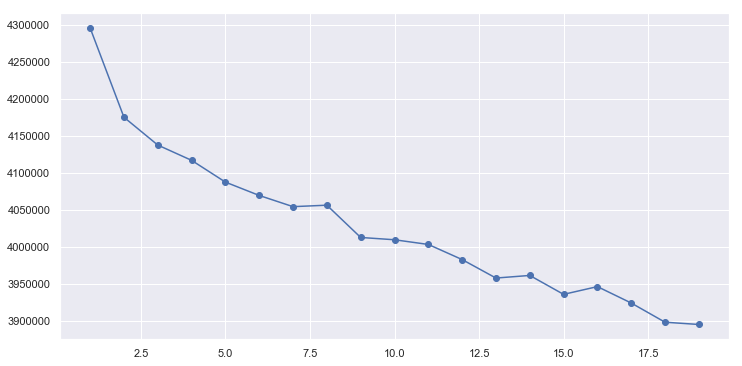

In [13]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

I decided instead to go with 10 clusters to start, the same as the number of genres I had, and see what that left me with.  I then plotted the 10 most common words to appear in those clusters.  As is apparent, there were a number of words that were duplicated across the 10 clusters, most of which were common name's like hank, jason, lily, etc.

In [14]:
# KMEANS with countvectorizer data

kmeans = KMeans(n_clusters = 10, n_jobs = -1)
kmeans.fit(vectorizer.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [16]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(feats[word] for word in centroid))

0 : ha, father, wa, love, friend, life, family, mother, day, tell
1 : ha, tell, wa, house, father, home, day, friend, mother, later
2 : mike, debt, game, hand, pay, play, decides, playing, win, winning
3 : jack, ha, tell, wa, father, new, life, family, try, later
4 : ha, kill, wa, police, escape, killed, man, car, tell, death
5 : jack, stone, say, tell, asks, know, want, dont, think, wa
6 : ha, life, film, love, wa, friend, family, man, father, wife
7 : wa, ha, tell, father, house, david, police, come, day, time
8 : george, ha, tell, house, bobby, day, wa, time, dog, family
9 : fred, nick, ha, north, christmas, present, mother, wa, make, brother


I then mapped those clusters onto a heatmap showing each genre's count in every cluster.  What I found was that none of the genre's save for drama and comedy were very prevalent in the clusters.  And drama and comedy were both in the same cluster.  Both of these facts were true no matter how many times I ran the clustering algorithm.  Comedy and drama always existing in the same cluster could be because they're both the two highest genres by count.  It could also be that comedies and dramas both tend to share similar word types in their plots (or similar plots themselves). 

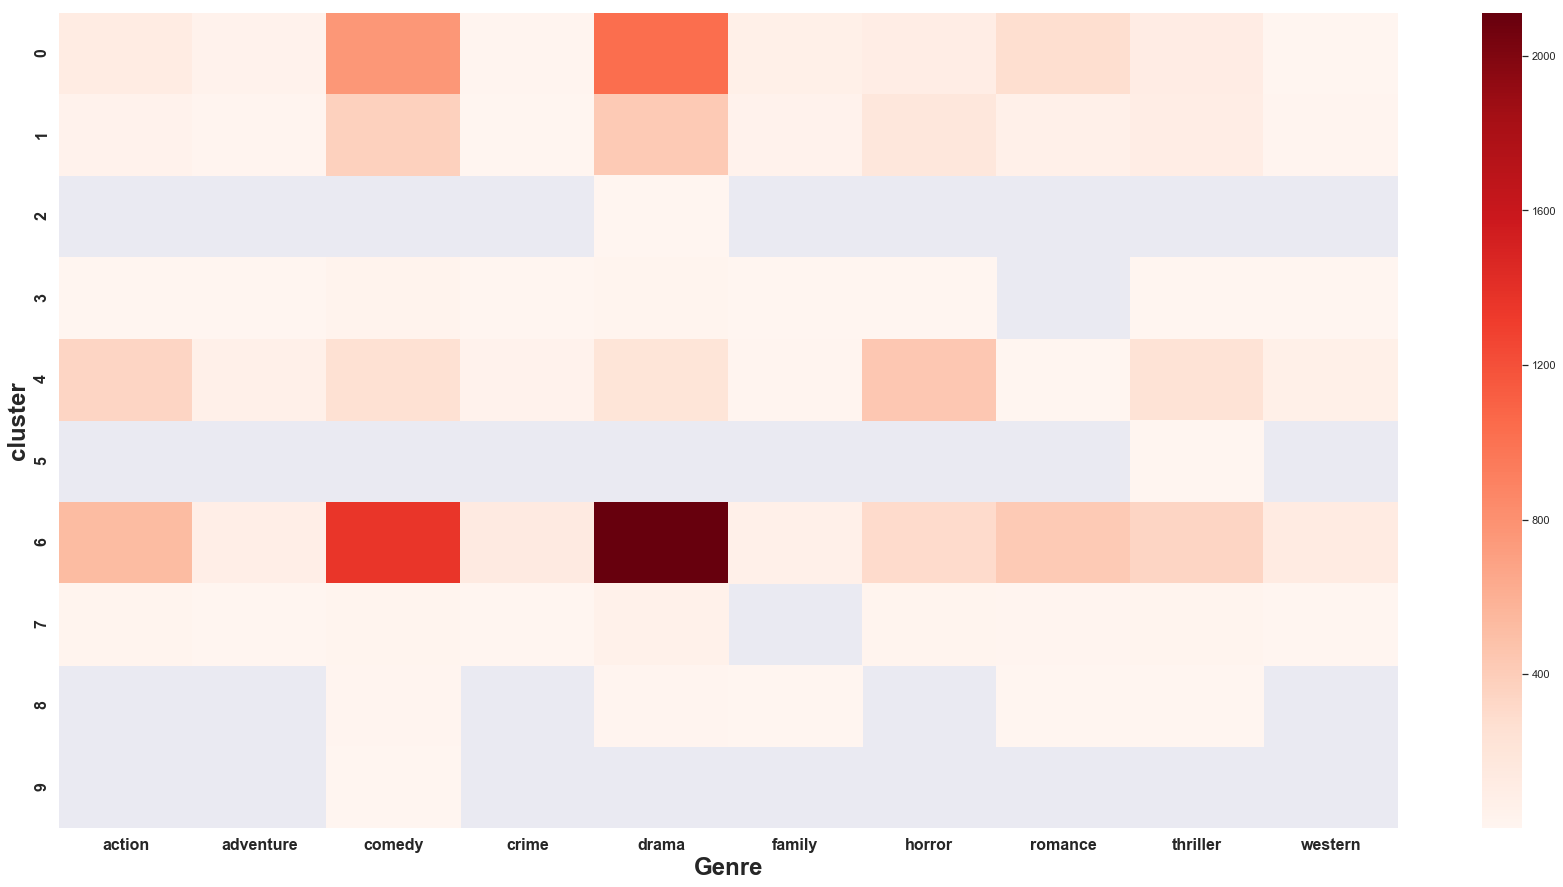

In [17]:
movies['cluster'] = kmeans.labels_
clusters = movies.groupby(['cluster', 'Genre']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'Genre'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Genre', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

### Clustering: Mean-Shift ###

Because the elbow chart didn't provide a good k for clustering, I decided to try mean-shift clustering, which would supply me with a k based on the data I gave it.  After running it, the supplied k it came up with was 155 separate clusters.  I decided to run a cluster grouping and heatmap as above to see what those would look like.

In [18]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(vectorizer.toarray(), quantile=0.2, n_samples=2000)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(vectorizer.toarray())

MeanShift(bandwidth=17.934431122936804, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=-1, seeds=None)

In [19]:
labels = ms.labels_
n_clusers_ = len(np.unique(labels))
print(n_clusers_)

155


In [21]:
common_words = ms.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(feats[word] for word in centroid))

0 : ha, life, wa, love, father, friend, film, family, come, man
1 : joan, jack, ralph, ha, meet, new, world, want, bus, captured
2 : man, car, wa, away, dead, woman, robbery, ha, door, leg
3 : george, judy, affair, tell, ha, train, home, plot, house, linda
4 : russell, favor, money, mr, billy, lee, john, mexican, group, dr
5 : lisa, johnny, ha, play, friend, stage, charles, message, decides, death
6 : oliver, jenny, father, love, tell, say, asks, hospital, paris, plan
7 : ross, frank, paul, john, money, leaving, sheriff, mexico, work, leg
8 : bruce, henry, team, end, player, new, change, friend, contract, parent
9 : chris, gordon, shoot, car, photo, music, suggests, driving, rape, school
10 : rocky, fight, upcoming, week, local, announces, round, ring, meet, begin
11 : bed, woman, artist, demon, brother, love, mother, ritual, owner, fell
12 : god, jerry, appears, given, believe, court, say, ha, tell, prove
13 : emma, company, ha, wayne, family, new, role, life, pregnant, professional
1

110 : victor, experiment, killing, ha, estate, create, escape, creature, hand, henry
111 : lee, kyle, police, strike, diane, union, help, wa, throw, owner
112 : mary, frank, foster, school, wa, problem, diane, life, custody, want
113 : taylor, alex, sophie, meet, away, car, head, town, driving, fall
114 : john, jamie, robert, barry, dave, bank, boyfriend, elizabeth, later, body
115 : rachel, michael, friend, rush, god, church, ha, priest, home, queen
116 : miss, mile, mr, say, boy, school, appears, child, suddenly, care
117 : harry, phil, young, professor, want, worried, doesnt, university, men, feel
118 : harold, albert, baby, home, local, child, ha, jeremy, later, couple
119 : baby, lucy, later, strip, fall, stage, head, club, dr, evening
120 : paul, kim, karl, place, police, officer, story, motorcycle, date, discover
121 : billy, jackie, tony, father, ha, dancing, later, professional, london, michael
122 : ali, minister, rival, west, saved, ha, video, tape, bag, work
123 : man, dog,

The heatmap looks mostly the same except expanded out immensly.  We still have the same problem where one cluster contains the majority of the counts in both drama and comedy, while the rest of the clusters only have counts in 1 or do of the categories.  If I were to redo this project, I might remove drama and comedy as they seem to be obsuring the clustering results for the genres with less movies.

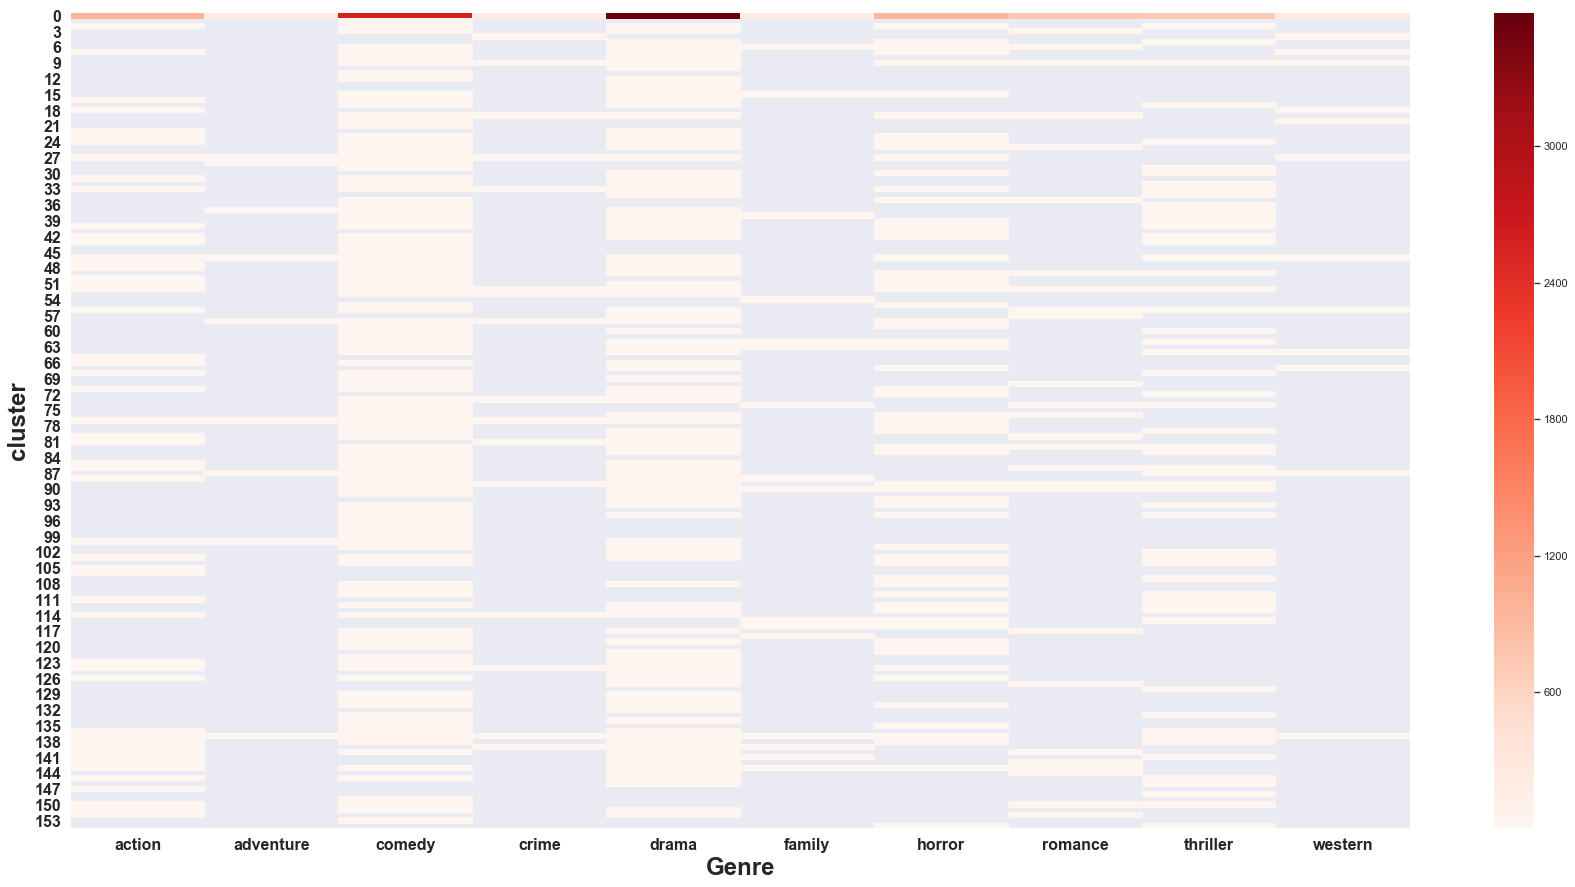

In [22]:
movies['cluster'] = ms.labels_
clusters = movies.groupby(['cluster', 'Genre']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'Genre'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Genre', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

Lastly I decided to run the CountVectorizer data through a random forest model to see if it would be able to predict genre based on plots.  Unfortunately, and unsuprisingly giving the clustering makeup, the predictive power of the model is not very good, and did not improve significantly even when I added in cluster groups as a feature.

In [23]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

counts_df['clusters'] = kmeans.labels_

rfc = ensemble.RandomForestClassifier()
Y = counts_df['Genre']
X = counts_df.drop(['Genre','Plot'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.2,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

C:\Users\micsa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training set score: 0.9859875444839857

Test set score: 0.4306049822064057


In [24]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rfc.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

features    scores
981       kill  0.008318
984    killing  0.007436
1078      love  0.006915
982     killed  0.005062
777         ha  0.004440
1318    police  0.004377
1043      life  0.004083
591     escape  0.003834
630       fall  0.003752
2000  clusters  0.003646

## What about TFIDF Though! ##

Even though CountVectorizing didn't produce good results, maybe another model will instead.  Here I decided to parse out the text and assign terms a score, a term-frequency individual document frequency to be exact.  This will count up the number of times a term occurs within sentences and assign it a score based on how rare that word is. 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

word_vectorizer = TfidfVectorizer(max_df=0.5, 
                             min_df=100, 
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

words = word_vectorizer.fit_transform(data)
features = word_vectorizer.get_feature_names()
tfidf_data = pd.DataFrame(words.toarray(), columns = list(word_vectorizer.get_feature_names()))

In [26]:
tfidf_data['Genre'] = df['Genre']

Here I decided to rerun my elbow chart, only using the tfidf data from above.  As with before, and perhaps more pronounced here, there is no specific point that denotes a good spot to pick k (between 1 and 20). Again I ended up just choosing 10 since it gave similar results as what I got via the 155 cluster grouping and only took a fraction of the processing time.

In [27]:
cluster_range = range(1, 20)
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans(num_clusters)
    clusters.fit(words.toarray())
    cluster_errors.append(clusters.inertia_)

In [28]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:10]

num_clusters  cluster_errors
0             1    10831.661755
1             2    10776.233927
2             3    10740.647794
3             4    10707.857764
4             5    10676.630919
5             6    10653.868165
6             7    10629.489567
7             8    10608.704874
8             9    10585.533056
9            10    10567.987490

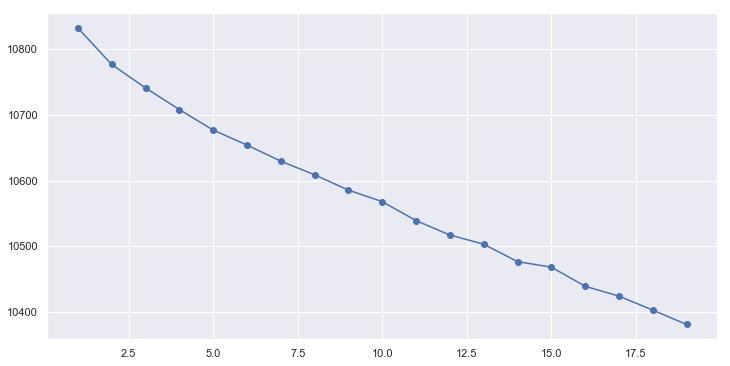

In [29]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [30]:
kmeans = KMeans(n_clusters = 10, n_jobs = -1)
kmeans.fit(words.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Again, using randomforestclassifier, the predictive power of the model is no better than what it had been using the CountVectorizer data. Even putting together the cluster groupings and heatmap shows that there are stark similarities between both models.

In [31]:
tfidf_data['clusters'] = kmeans.labels_

rfc = ensemble.RandomForestClassifier()
Y = tfidf_data['Genre']
X = tfidf_data.drop(['Genre'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9848754448398577

Test set score: 0.4219306049822064


In [32]:
importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rfc.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

features    scores
1381      kill  0.008189
1498      love  0.008158
2783  clusters  0.006343
1454      life  0.005748
1382    killed  0.005552
1384   killing  0.005547
651      death  0.005268
867     escape  0.004396
1824    police  0.004237
1636    murder  0.004184

In [33]:
# KMEANS with TFIDF data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10, n_jobs = -1)
kmeans.fit(words)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [34]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(features[word] for word in centroid))

0 : david, harry, michael, wa, house, home, tell, friend, father, time
1 : police, gang, wa, officer, kill, murder, ram, vijay, inspector, brother
2 : family, mother, father, school, child, home, wa, life, house, son
3 : kill, wa, car, escape, house, killed, tell, police, john, men
4 : film, story, movie, life, character, role, woman, love, wa, young
5 : life, woman, new, friend, young, team, man, wife, wa, make
6 : jack, father, wa, tell, new, life, try, wife, boy, friend
7 : frank, father, house, wa, son, helen, mother, new, tell, joe
8 : village, raja, krishna, villager, father, love, son, family, life, story
9 : love, marriage, fall, father, family, friend, marry, come, girl, life


In [35]:
movies['cluster'] = kmeans.labels_

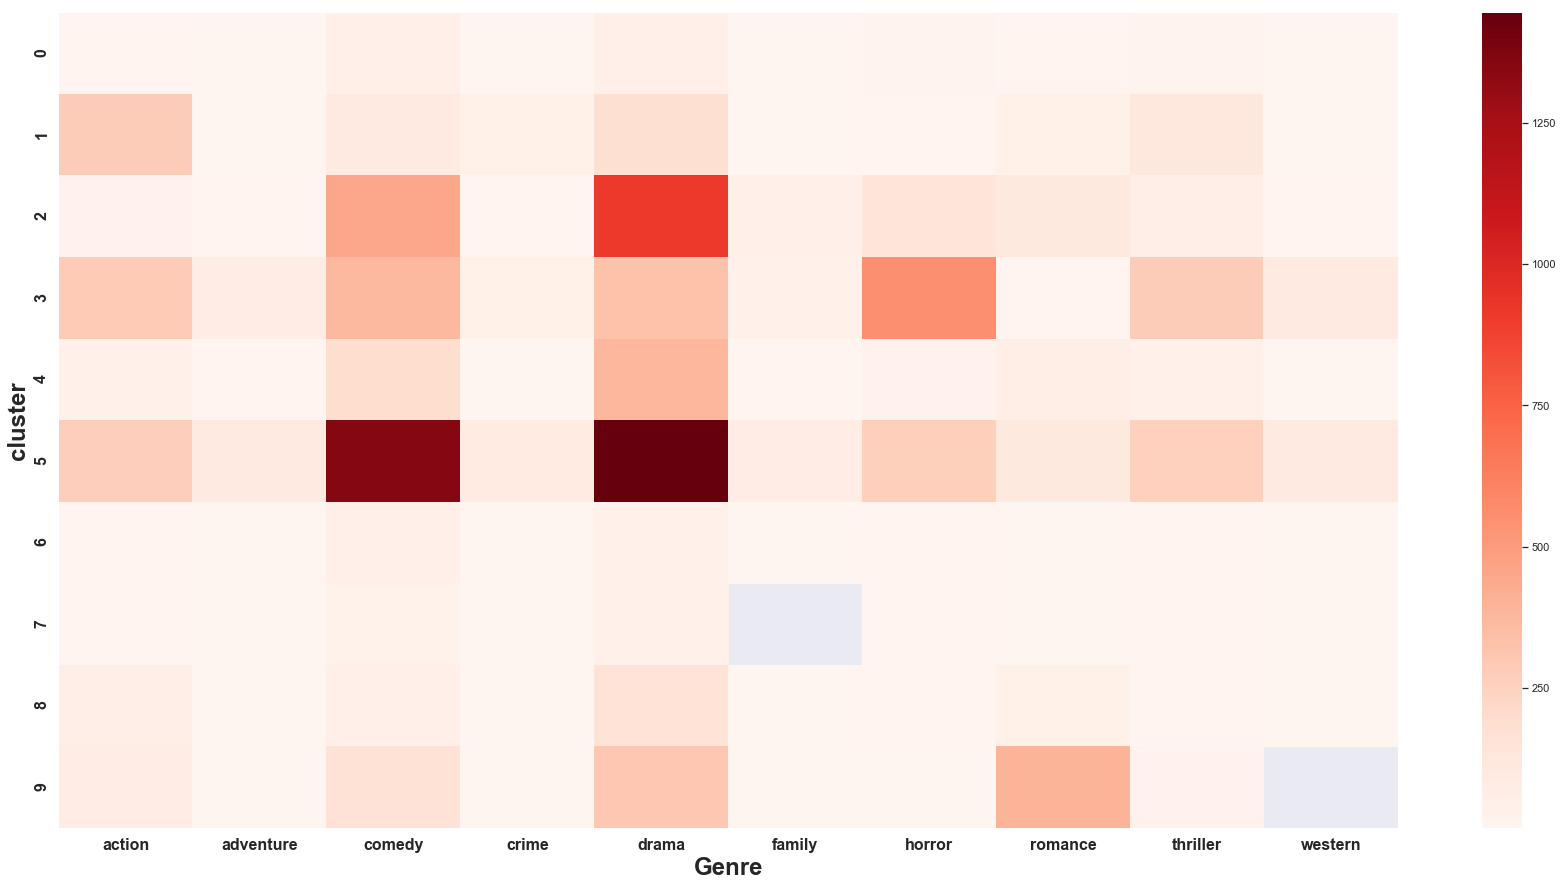

In [36]:
clusters = movies.groupby(['cluster', 'Genre']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'Genre'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('Genre', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

## Concluding Thoughts ##
Overall, this model did not predict which genre a movie belonged to as well as I would have liked it to, based on plot summaries.  As stated above, this could be for a number of reasons.  Maybe there were too many comedy and drama films which made it hard for the model to predict movies that weren't those.  Maybe movie plot summaries are too generic, and that there are not enough distinguishing words between different genres, or that they're still being overshadowed by the prevalence of more common words/names. 
<br>
<br>
Going forward, if I were to reanalyze this data, I would probably remove comedy and drama (or at least break them up somehow) and I would try and clean up more of the common words that weren't removed via the stop_words corpus.  Maybe removing all names might have improved things slightly.  It could be, however, that this data was simply too generic across all genres to really be able to adequately answer my question.